# Analysis of Real Estates in King County, Seattle 

## Overview

Overview with what our recommendations will be

## Business Problem

business problem

## Data

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.dummy import DummyRegressor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
pd.set_option('display.max_columns', None) #shows all columns on dataframe
pd.set_option('display.float_format', lambda x: '%.2f' % x) #applied to every df in this notebook

In [49]:
df = pd.read_csv('./data/kc_house_data.csv')

In [50]:
#checking the data
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.00,3,1.00,1180,5650,1.00,NaN,NONE,Average,7 Average,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,12/9/2014,538000.00,3,2.25,2570,7242,2.00,NO,NONE,Average,7 Average,2170,400.0,1951,1991.00,98125,47.72,-122.32,1690,7639
2,5631500400,2/25/2015,180000.00,2,1.00,770,10000,1.00,NO,NONE,Average,6 Low Average,770,0.0,1933,nan,98028,47.74,-122.23,2720,8062
3,2487200875,12/9/2014,604000.00,4,3.00,1960,5000,1.00,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2/18/2015,510000.00,3,2.00,1680,8080,1.00,NO,NONE,Average,8 Good,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Summary of what we notice, what potential columns we want

## Initial Cleaning

In [52]:
#checking condition
df['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

Difficult to make reccomendation base off of this since there's a lot of ways to define these terms so decided to use grade which is a little less vague.

In [53]:
#dropping nulls base off view
df_copy = df.copy()
df_copy = df_copy.dropna(subset = ['view'])

We are dropping the nulls based off nulls because view is a column of interest for us.

In [54]:
#dropping multiple entries of same place 
df_copy = df_copy.sort_values(by=['id', 'date'])
df_copy = df_copy.drop_duplicates(subset=['id'], keep='last')

Rational of the dropping of duplicates

## Exploring Data

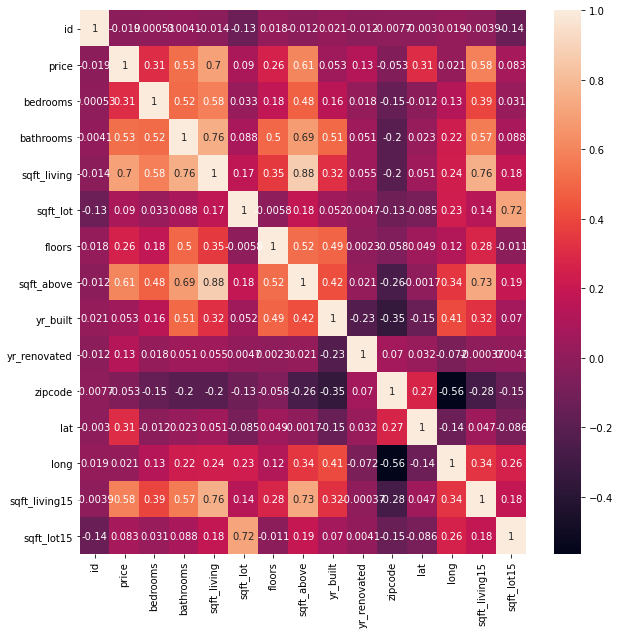

In [55]:
#looking at correlations
fig, ax = plt.subplots(figsize=(10,10))
heat = sns.heatmap(df_copy.corr(), annot = True)

Summary of what we notice and potential problem

In [56]:
df_copy.groupby('view').mean()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
view,,,,,,,,,,,,,,,
AVERAGE,4780987779.11,791956.68,3.57,2.43,2651.20,22331.72,1.51,2083.87,1964.82,128.57,98090.98,47.56,-122.24,2427.20,17364.67
EXCELLENT,4970006204.50,1453795.18,3.63,2.78,3337.17,21762.46,1.60,2509.69,1965.77,331.97,98096.41,47.58,-122.26,2838.68,18994.11
FAIR,4604598059.83,814386.56,3.53,2.35,2573.51,12342.66,1.39,1936.88,1962.90,180.02,98096.60,47.58,-122.29,2408.13,10753.88
GOOD,4346605769.28,972809.66,3.67,2.67,3012.47,35010.67,1.57,2276.73,1967.34,239.63,98092.44,47.55,-122.24,2697.59,23983.25
NONE,4572504059.05,497472.12,3.35,2.07,2001.17,14178.46,1.49,1749.66,1971.73,72.10,98076.21,47.56,-122.21,1926.60,12179.02


visually the price of average, fair and good look the about the same so we would need to run a significant test to see. Excellent and none looks to be potentially significant. Need to use anova here to see and ad-hoc tests

#### Initiating Train-Split? Here?

#### View Analysis

is there a difference between those that have a view versus those that don't

In [57]:
summary_of_view = df_copy.groupby('view').mean()

from the df summary, we notice that there is a difference in price between price for those that are excellent
compared to those that have a view written as none. Further investigation will be performed to determine if this
difference is statistically significant

In [58]:
df_average = df_copy[df_copy['view'] == 'AVERAGE']
df_excellent = df_copy[df_copy['view'] == 'EXCELLENT']
df_fair = df_copy[df_copy['view'] == 'FAIR']
df_good = df_copy[df_copy['view'] == 'GOOD']
df_none = df_copy[df_copy['view'] == 'NONE']

Subsetting the data into different views
 - number of rows: none = 19422, avg = 957, good = 508, fair = 330, excellent = 317, norecord = 17

In [59]:
fvalue, pvalue = stats.f_oneway(df_average['price'], df_excellent['price'], df_fair['price'],
                                df_good['price'] , df_none['price'])

In [60]:
#creating df of just view
df_view = df_copy[['view', 'price']]

#Tukey test
print(pairwise_tukeyhsd(df_view['price'], df_view['view']))

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1    group2    meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------------
  AVERAGE EXCELLENT  661838.4963  0.001  602455.3172  721221.6753   True
  AVERAGE      FAIR   22429.8804 0.8103  -35925.3814   80785.1422  False
  AVERAGE      GOOD  180852.9845  0.001  130629.6173  231076.3517   True
  AVERAGE      NONE -294484.5601  0.001 -324736.2482 -264232.8721   True
EXCELLENT      FAIR -639408.6159  0.001 -711436.0704 -567381.1614   True
EXCELLENT      GOOD -480985.5118  0.001 -546598.0428 -415372.9808   True
EXCELLENT      NONE -956323.0564  0.001 -1008263.236 -904382.8769   True
     FAIR      GOOD  158423.1041  0.001    93739.421  223106.7872   True
     FAIR      NONE -316914.4405  0.001 -367676.2065 -266152.6746   True
     GOOD      NONE -475337.5446  0.001   -516493.43 -434181.6592   True
---------------------------------------------------

Average and Fair are not significant to each other, so they should be grouped together. Each other subset should be on their
owen as they have a p value of under .05

#### Grade Analysis

 Is there a difference between grades

In [61]:
df_copy.grade.value_counts()

7 Average        8863
8 Good           6029
9 Better         2595
6 Low Average    1988
10 Very Good     1126
11 Excellent      394
5 Fair            234
12 Luxury          87
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

issue here that there are many different grade and some of them have very little that can skew the perception such as poor having 1, mansion having 13, low = 27, luxury having 87

In [62]:
#dropping poor row
df3 = df_copy.copy()
df3 = df3[df3['grade'] != '3 Poor']

In [63]:
df_10 = df_copy[df_copy['grade'] == '10 Very Good']
df_11 = df_copy[df_copy['grade'] == '11 Excellent']
df_12 = df_copy[df_copy['grade'] == '12 Luxury']
df_4 = df_copy[df_copy['grade'] == '4 Low']
df_5 = df_copy[df_copy['grade'] == '5 Fair']
df_6 = df_copy[df_copy['grade'] == '6 Low Average']
df_7 = df_copy[df_copy['grade'] == '7 Average']
df_8 = df_copy[df_copy['grade'] == '8 Good']
df_9 = df_copy[df_copy['grade'] == '9 Better']

In [64]:
f_value_grade, p_value_grade = stats.f_oneway(df_10['price'], df_11['price'], df_12['price'],
                                df_4['price'] , df_5['price'], df_6['price'], df_7['price'],df_8['price'],
                                              df_9['price'])

There is a significant difference in price betweeen grades but we don't know which one is significant.
Further testing required to determine which is important

In [65]:
#ad-hoc test
df_grade = df_copy[['grade', 'price']]

print(pairwise_tukeyhsd(df_grade['price'], df_grade['grade']))

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
    group1        group2       meandiff   p-adj      lower         upper     reject
-----------------------------------------------------------------------------------
 10 Very Good  11 Excellent   426433.5346  0.001   378539.5661    474327.503   True
 10 Very Good     12 Luxury  1106449.2054  0.001  1015399.6321  1197498.7788   True
 10 Very Good    13 Mansion  2638885.1029  0.001  2410642.1766  2867128.0292   True
 10 Very Good        3 Poor  -809884.1279 0.0555 -1628479.1491     8710.8933  False
 10 Very Good         4 Low   -859882.276  0.001 -1019227.8161   -700536.736   True
 10 Very Good        5 Fair  -824232.8416  0.001  -883018.1317  -765447.5514   True
 10 Very Good 6 Low Average  -769377.8658  0.001  -799896.0194  -738859.7122   True
 10 Very Good     7 Average  -669427.2193  0.001  -695313.9838  -643540.4548   True
 10 Very Good        8 Good  -528666.0251  0.001   -555229.771  -502102.2791

Summary of what we notice

#### One Hot Encoding | Rework to include Train only

In [66]:
#categorizing average and fair together since they are not different from each other
df3['view'] = df3['view'].str.replace('AVERAGE', 'FAIR')

In [67]:

#making the categorical variable
cate_column = df3[['grade', 'view']]

cate_column

,grade,view
2494,7 Average,NONE
6729,8 Good,NONE
8404,7 Average,NONE
8800,6 Low Average,NONE
3553,7 Average,NONE
...,...,...
16723,7 Average,NONE
3257,7 Average,NONE
7614,7 Average,NONE
20963,9 Better,NONE


In [68]:
ohe = OneHotEncoder(drop='first')

column_name = ['grade', 'view']
features = cate_column.copy()

features2 = features[column_name]

cate_ohe = ohe.fit_transform(features2)

cate_ohe

<21356x12 sparse matrix of type '<class 'numpy.float64'>'
	with 41272 stored elements in Compressed Sparse Row format>

In [69]:
name = ohe.get_feature_names()

In [70]:
cate_parsed = pd.DataFrame(cate_ohe.todense(), columns = name, index = features.index)
cate_parsed

,x0_11 Excellent,x0_12 Luxury,x0_13 Mansion,x0_4 Low,x0_5 Fair,x0_6 Low Average,x0_7 Average,x0_8 Good,x0_9 Better,x1_FAIR,x1_GOOD,x1_NONE
2494,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
6729,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
8404,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
8800,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
3553,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
16723,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
3257,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
7614,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
20963,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00


#### Scaling | Rework only to include train

In [71]:
numbers = df_copy.select_dtypes(np.number)

In [72]:
df_2 = numbers.drop(['id', 'lat', 'long', 'zipcode'], axis = 1)
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21357 entries, 2494 to 15937
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21357 non-null  float64
 1   bedrooms       21357 non-null  int64  
 2   bathrooms      21357 non-null  float64
 3   sqft_living    21357 non-null  int64  
 4   sqft_lot       21357 non-null  int64  
 5   floors         21357 non-null  float64
 6   sqft_above     21357 non-null  int64  
 7   yr_built       21357 non-null  int64  
 8   yr_renovated   17565 non-null  float64
 9   sqft_living15  21357 non-null  int64  
 10  sqft_lot15     21357 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 2.0 MB


In [73]:
#Rework to include only the train
ss = StandardScaler()

columns_name1 = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'sqft_above']
numbers_scaling = df_2.copy().drop(['yr_renovated','sqft_lot15', 'sqft_lot', 'yr_built'], axis = 1)

features= numbers_scaling[columns_name1]

scale1 = ss.fit(features)
scale2 = scale1.transform(features)
numbers_scaling[columns_name1] = scale2

numbers_scaling

,price,bedrooms,bathrooms,sqft_living,floors,sqft_above,sqft_living15
2494,-0.71,2.84,1.15,0.35,0.93,0.73,2060
6729,0.29,0.68,-0.48,-0.02,-0.92,-0.76,2590
8404,-0.38,-0.40,-1.46,-0.68,-0.92,-0.40,2250
8800,-0.83,-0.40,-1.46,-0.71,0.01,-0.94,1290
3553,-0.38,0.68,-0.15,-0.47,-0.92,-1.24,1480
...,...,...,...,...,...,...,...
16723,-0.48,1.76,-0.15,-0.53,0.01,-0.23,1190
3257,-0.44,-1.48,-1.46,-1.14,-0.92,-1.15,1930
7614,-0.55,-0.40,-1.46,-1.07,-0.92,-1.29,1510
20963,-0.38,-1.48,-0.48,-0.73,0.01,-1.08,1440


In [74]:
#combinig scale and ohe
scaled_and_parse_df = pd.concat([numbers_scaling, cate_parsed], axis = 1)

## Linear Regression | Rework so fit is only on train and not test

#### simple linear

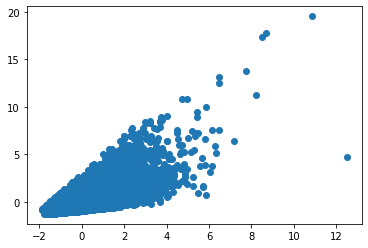

In [75]:
fig, ax = plt.subplots()

x = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df['price']


ax.scatter(x, y);

In [76]:
np.corrcoef(df['sqft_living'],df['price'])

array([[1.       , 0.7019173],
       [0.7019173, 1.       ]])

passing our first assumption.Based on our scatterplot, we can see that there is a strong correlation between sqft_living and price.our pearson correlation coefficiant of .70 suggests that these two variables are strongly correlated. Refer to the heatmap above to multicollinearity 

In [77]:
#Create & Instantiate a DummyRegressor

dummy_reg = DummyRegressor()

In [78]:
#Define X and y variable using scaled & parse dataframe

X_s_p = scaled_and_parse_df['sqft_living']
y_s_p = scaled_and_parse_df['price']

In [79]:
preds = sk_lr.predict(X)

NameError: name 'sk_lr' is not defined

In [ ]:
X = scaled_and_parse_df[['sqft_living']]
y = scaled_and_parse_df['price']

In [ ]:
resids = y - preds
resids

In [ ]:
#Create out bins

bins = int( len(X)**.5)
bins

In [ ]:
# Histogram of residuals

plt.hist(resids, bins=bins);

In [ ]:
sns.displot(resids, bins=bins, kde=True)

In [ ]:
sm.qqplot(resids, line='r');

In [ ]:
# resid plot sns.resid

sns.residplot(x=X, y=y);

In [ ]:
plt.scatter(preds, resids)

In [ ]:
#Fit the dummy_regressor

dummy_reg.fit(X_s_p,y_s_p)

In [ ]:
# Score it

dummy_reg.score(X_s_p,y_s_p)

In [ ]:
# Creating a straightforward, initial model --
# just for kicks
simple_formula = 'price ~ sqft_living'
simple_model = ols(formula = simple_formula,
                   data = scaled_and_parse_df).fit()
simple_mod_summ = simple_model.summary()

simple_mod_summ

In [ ]:
#test on our test data set

Summary comparison between the two

#### Multiple regression | Rework to train data

Slowly adding in other variables

In [ ]:
fig, ax = plt.subplots(ncols=2,figsize=(15,5))

x1 = scaled_and_parse_df[['sqft_living']]
y1 = scaled_and_parse_df[['price']]

x2 = scaled_and_parse_df[['bedrooms']]

ax[0].scatter(x1, y1)
ax[1].scatter(x2,y1);

#Upon looking at our scaled dataframe, we noticed that there is a house sold with 33 bedrooms for $600k
#After considering the price sold, sqft and number of bathrooms - the # of bedrooms appears 
#to be an error of somesort
#Since we explored bedrooms having a relatively small correlation to price, we are not too worried about this one
#outlier being included in our scatterplot

In [ ]:
simple_formula3 = 'price ~ sqft_living + bedrooms'
simple_model3 = ols(formula = simple_formula3,
                   data = scaled_and_parse_df).fit()
simple_mod_summ3 = simple_model3.summary()

simple_mod_summ3